In [7]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
stops = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
%matplotlib inline

In [8]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Import dataset

In [10]:
df=pd.read_csv('LibCon03-06-2018.csv')

df.shape

(3842, 18)

Seperate the Conservative dataset 

In [11]:
df=df[df['subreddit']=='Conservative'] 


In [12]:
df.shape

(2184, 18)

/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


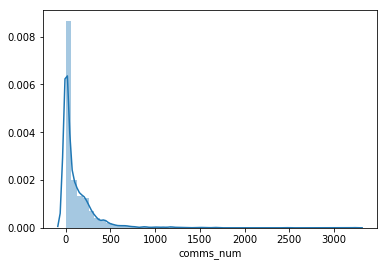

In [13]:
sns.distplot(df['comms_num']);


/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


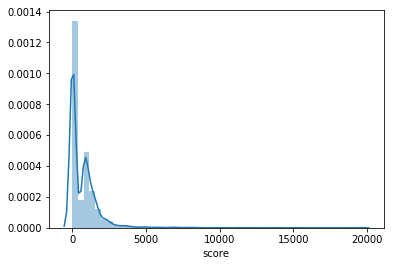

In [14]:
sns.distplot(df['score']);

In [15]:
print('Scores')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.score),np.median(df.score)))
print('Number of coments')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.comms_num),np.median(df.comms_num)))



Scores
Mean is 728.83 and the Median is 224.00
Number of coments
Mean is 123.28 and the Median is 34.00


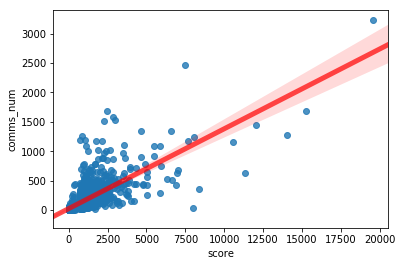

In [16]:
#Examine the relationship between score and number of comments 
sns.regplot(x=df['score'], y=df["comms_num"], 
            line_kws={"color":"r","alpha":0.7,"lw":5});

There is low correlation between the variables

In [17]:
df['score'].corr(df['comms_num'])

0.7615971483129651

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2184 entries, 0 to 3841
Data columns (total 18 columns):
body                33 non-null object
comms_num           2184 non-null int64
created             2184 non-null float64
domain              2184 non-null object
id                  2184 non-null object
score               2184 non-null int64
subreddit           2184 non-null object
time_retrieved      2184 non-null object
title               2184 non-null object
time                2184 non-null object
time_retrieved.1    2184 non-null object
post_duration       2184 non-null float64
time_hm             2184 non-null int64
day                 2184 non-null object
word_count          2184 non-null int64
sent_sia            2184 non-null float64
sentiment           2184 non-null float64
subjectivity        2184 non-null float64
dtypes: float64(5), int64(4), object(9)
memory usage: 324.2+ KB


In [19]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop(["score","comms_num"])
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_num = df[numerical_features]
df_cat = df[categorical_features]

Numerical features : 7
Categorical features : 9


In [21]:
df.head(2)

,body,comms_num,created,domain,id,score,subreddit,time_retrieved,title,time,time_retrieved.1,post_duration,time_hm,day,word_count,sent_sia,sentiment,subjectivity
0,NaN,1,1.527722e+09,medium.com,8n9e7d,1,Conservative,2018-05-30 22:07:10.938189+00:00,The Day I Learned We Had a Fake News Problem,2018-05-30 23:17:28.000000,2018-05-30 22:07:10.938189,23.0,23,Sun,10,-0.38,-0.5,1.0
1,NaN,0,1.527281e+09,medium.com,8m1ean,8,Conservative,2018-05-30 22:07:10.938189+00:00,Jordan Peterson LBC Interview: A Few Highlights,2018-05-25 20:35:45.000000,2018-05-30 22:07:10.938189,2.0,20,Sun,7,-0.48,-0.2,0.1


Assign sentiment labels for visualization

In [22]:
df['sent_label'] = 'neutral'
df.loc[df['sentiment'] > 0.1, 'sent_label'] = 'positive'
df.loc[df['sentiment'] < -0.1, 'sent_label'] = 'negative'
df.head(3)
    

,body,comms_num,created,domain,id,score,subreddit,time_retrieved,title,time,time_retrieved.1,post_duration,time_hm,day,word_count,sent_sia,sentiment,subjectivity,sent_label
0,NaN,1,1.527722e+09,medium.com,8n9e7d,1,Conservative,2018-05-30 22:07:10.938189+00:00,The Day I Learned We Had a Fake News Problem,2018-05-30 23:17:28.000000,2018-05-30 22:07:10.938189,23.0,23,Sun,10,-0.38,-0.50,1.00,negative
1,NaN,0,1.527281e+09,medium.com,8m1ean,8,Conservative,2018-05-30 22:07:10.938189+00:00,Jordan Peterson LBC Interview: A Few Highlights,2018-05-25 20:35:45.000000,2018-05-30 22:07:10.938189,2.0,20,Sun,7,-0.48,-0.20,0.10,negative
2,NaN,0,1.527121e+09,thefederalist.com,8lko53,7,Conservative,2018-05-30 22:07:10.938189+00:00,James Clapper Just Lied Again About His Previo...,2018-05-24 00:21:14.000000,2018-05-30 22:07:10.938189,22.0,0,Sun,12,0.59,-0.17,0.17,negative


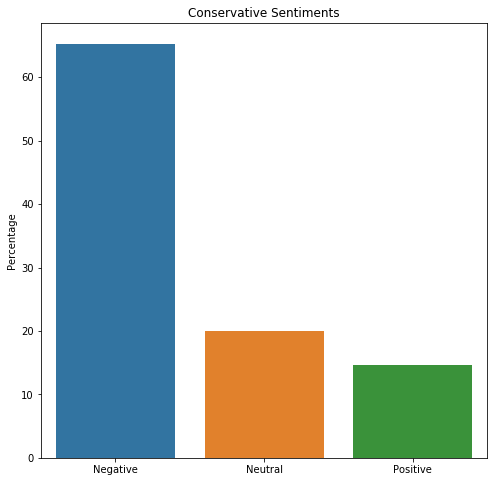

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.sent_label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
ax.set_title("Conservative Sentiments")
plt.show()

Distribution of the post duration

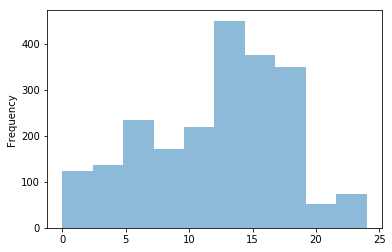

In [24]:
df['post_duration'].plot(kind='hist', alpha=.5);

Most reposted domains

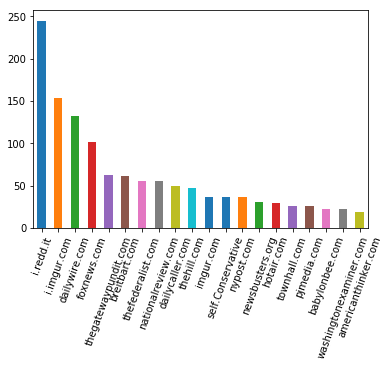

In [25]:
df['domain'].value_counts().head(20).plot(kind='bar')
plt.xticks(rotation=70);

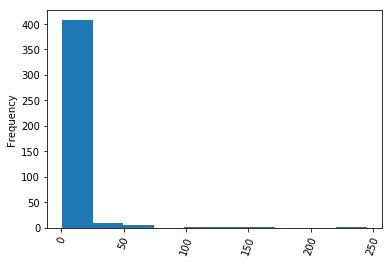

In [26]:
df['domain'].value_counts().plot(kind='hist')
plt.xticks(rotation=70);

In [27]:
DD= df['domain'].value_counts().head(30).index.tolist() 

df['domain_d'] = [type_ if type_ in DD
                      else "OTHER" for type_ in df['domain']]
df['domain_d'].value_counts()

OTHER                     792
i.redd.it                 245
i.imgur.com               153
dailywire.com             132
foxnews.com               102
thegatewaypundit.com       63
breitbart.com              61
nationalreview.com         55
thefederalist.com          55
dailycaller.com            50
thehill.com                47
self.Conservative          37
imgur.com                  37
nypost.com                 37
newsbusters.org            31
hotair.com                 29
townhall.com               26
pjmedia.com                26
washingtonexaminer.com     22
babylonbee.com             22
americanthinker.com        19
spectator.org              18
washingtontimes.com        18
redstate.com               16
m.washingtontimes.com      14
reuters.com                14
ijr.com                    13
cnsnews.com                13
freebeacon.com             13
latimes.com                12
theblaze.com               12
Name: domain_d, dtype: int64

In [28]:
df['word_count'] = df['word_count'].round(2)

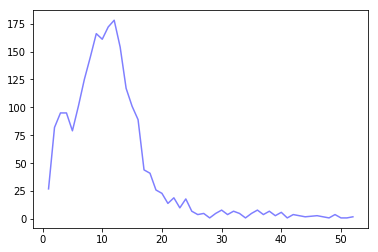

In [29]:
df['word_count'].value_counts().sort_index().plot(color='b', alpha=.5);

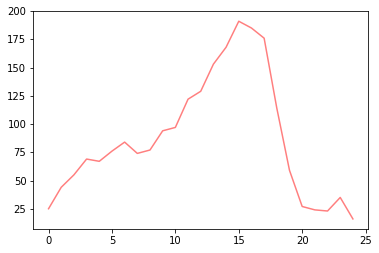

In [30]:
df['post_duration'].value_counts().sort_index().plot(color='r', alpha=.5);

In [31]:
le=LabelEncoder()
X = df[['word_count','sentiment','subjectivity','domain','post_duration']]
X_n=df[['word_count','sentiment','subjectivity','domain','title','post_duration']]
# y=df_combined['subreddit']
# transform the label 
y = le.fit_transform(df['subreddit'])

## Feature Engineering

In [32]:
print('Scores')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.score),np.median(df.score)))
print('Number of coments')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.comms_num),np.median(df.comms_num)))



Scores
Mean is 728.83 and the Median is 224.00
Number of coments
Mean is 123.28 and the Median is 34.00


In [33]:
df['com_label'] = np.where(df['comms_num']>=np.median(df.comms_num), 'High', 'Low')
df['score_label'] = np.where(df['score']>=np.median(df.score), 'High', 'Low')

In [34]:
#non_nlp variables 
X = df[['word_count','sentiment','subjectivity','domain_d','post_duration']]
# y=df_combined['subreddit']
# transform the label 



y_cm = LabelEncoder().fit_transform(df['com_label'])#Comments
y_sc = LabelEncoder().fit_transform(df['score_label'])# Score


In [35]:

df.corr()

,comms_num,created,score,post_duration,time_hm,word_count,sent_sia,sentiment,subjectivity
comms_num,1.000000,-0.389290,0.761597,0.158713,0.178627,-0.095024,-0.009324,0.009691,-0.035792
created,-0.389290,1.000000,-0.392120,-0.118578,-0.121629,0.134091,0.013078,0.003134,-0.022655
score,0.761597,-0.392120,1.000000,0.107120,0.133846,-0.121756,0.017669,0.012617,-0.028645
post_duration,0.158713,-0.118578,0.107120,1.000000,0.474458,-0.021949,-0.010237,-0.002059,0.019987
time_hm,0.178627,-0.121629,0.133846,0.474458,1.000000,-0.024682,0.014212,0.002434,-0.003288
word_count,-0.095024,0.134091,-0.121756,-0.021949,-0.024682,1.000000,0.003804,0.029858,0.180258
sent_sia,-0.009324,0.013078,0.017669,-0.010237,0.014212,0.003804,1.000000,0.013038,-0.020313
sentiment,0.009691,0.003134,0.012617,-0.002059,0.002434,0.029858,0.013038,1.000000,0.027124
subjectivity,-0.035792,-0.022655,-0.028645,0.019987,-0.003288,0.180258,-0.020313,0.027124,1.000000


In [36]:
def corr_map(df, figsize=(20,10), mask_val = None):
    # Make correlation heat map from pandas dataframe
    # pass a value to mask_val to only see correlations
    # above a certain value (the absolute value of the correlation)

    # Arguments:
    # df - pandas dataframe to with data for heatmap
    # figsize - size of resulting figure (width, height), default: (15, 10) (inches?)
    # mask_val - threshold for displaying correlations, default: None

    corr = df.corr()    
    
    # Make mask to only show bottom triangle
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(corr)] = True
    
    # Add to the mask (if mask_val passed)
    if (mask_val != None):
        mask[abs(corr) < mask_val] = True
    
    # Make heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2g')
    pass

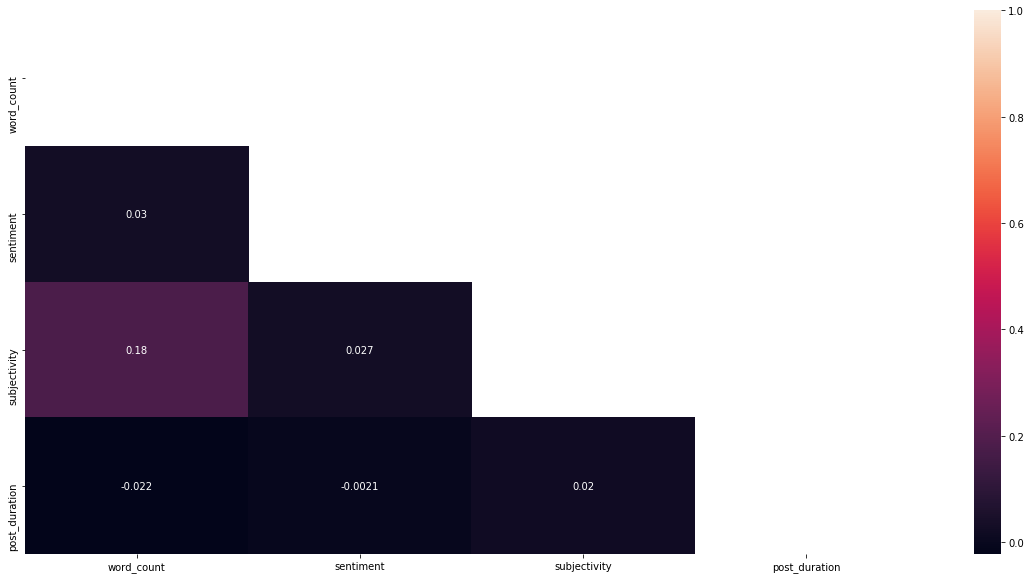

In [37]:
corr_map(X)

Correlation between word count and subjectivity .. verbose people are more objective?

In [38]:
df['domain_d'].nunique()

31

In [40]:
#286 domains .. need to condense
DD= df['domain'].value_counts().head(30).index.tolist()


df['domain_d'] = [type_ if type_ in DD
                      else "OTHER" for type_ in df['domain']]
print(df['domain_d'].nunique())

31


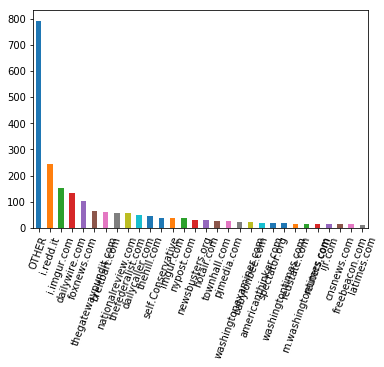

In [41]:
df['domain_d'].value_counts().head(30).plot(kind='bar')
plt.xticks(rotation=70);

***Text Preprossesing**

In [42]:
df['text']=df['title'].str.replace('\d+', '')
# df_lib_con.title = df_lib_con.title.str.replace('\d+', '')

def process_lem(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text)
    
    lemmer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    return ' '.join([lemmer.lemmatize(word) for word in tokens if not word in stop_words])

df['text'] = [process_lem(text) for text in df['text']]




In [43]:
df.head(5)

,body,comms_num,created,domain,id,score,subreddit,time_retrieved,title,time,...,day,word_count,sent_sia,sentiment,subjectivity,sent_label,domain_d,com_label,score_label,text
0,NaN,1,1.527722e+09,medium.com,8n9e7d,1,Conservative,2018-05-30 22:07:10.938189+00:00,The Day I Learned We Had a Fake News Problem,2018-05-30 23:17:28.000000,...,Sun,10,-0.38,-0.50,1.00,negative,OTHER,Low,Low,day learned fake news problem
1,NaN,0,1.527281e+09,medium.com,8m1ean,8,Conservative,2018-05-30 22:07:10.938189+00:00,Jordan Peterson LBC Interview: A Few Highlights,2018-05-25 20:35:45.000000,...,Sun,7,-0.48,-0.20,0.10,negative,OTHER,Low,Low,jordan peterson lbc interview highlight
2,NaN,0,1.527121e+09,thefederalist.com,8lko53,7,Conservative,2018-05-30 22:07:10.938189+00:00,James Clapper Just Lied Again About His Previo...,2018-05-24 00:21:14.000000,...,Sun,12,0.59,-0.17,0.17,negative,thefederalist.com,Low,Low,james clapper lied previous lie nsa spying
3,NaN,1,1.527116e+09,powerlineblog.com,8lk0tw,8,Conservative,2018-05-30 22:07:10.938189+00:00,"James Clapper: Leaker, Liar & Sleazeball",2018-05-23 22:59:03.000000,...,Sun,6,0.00,0.00,0.00,neutral,OTHER,Low,Low,james clapper leaker liar sleazeball
4,NaN,6,1.527159e+09,oann.com,8lpd1h,3,Conservative,2018-05-30 22:07:10.938189+00:00,452 Caravan Illegal Aliens Broke Into U.S. & A...,2018-05-24 10:54:06.000000,...,Sun,16,0.00,-0.25,0.75,negative,OTHER,Low,Low,caravan illegal alien broke u likely stay inde...


In [44]:
#nSelecting the featureset

X = df[['word_count','sentiment','subjectivity','domain_d','post_duration','title','text']]
le=LabelEncoder()

y_cm = le.fit_transform(df['com_label'])#Comments
y_sc = le.fit_transform(df['score_label'])# Score


In [45]:
X_d = pd.get_dummies(X, columns=['domain_d'], drop_first=True)

In [46]:
X_d.head(2)

,word_count,sentiment,subjectivity,post_duration,title,text,domain_d_americanthinker.com,domain_d_babylonbee.com,domain_d_breitbart.com,domain_d_cnsnews.com,...,domain_d_reuters.com,domain_d_self.Conservative,domain_d_spectator.org,domain_d_theblaze.com,domain_d_thefederalist.com,domain_d_thegatewaypundit.com,domain_d_thehill.com,domain_d_townhall.com,domain_d_washingtonexaminer.com,domain_d_washingtontimes.com
0,10,-0.5,1.0,23.0,The Day I Learned We Had a Fake News Problem,day learned fake news problem,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,-0.2,0.1,2.0,Jordan Peterson LBC Interview: A Few Highlights,jordan peterson lbc interview highlight,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
y_cm.shape

(2184,)

Non-NLP **Comments**

In [48]:
X_c=X_d.drop(['title','text'],axis=1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y_cm, test_size=0.5, random_state=42)

In [50]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [51]:
lr.fit(X_train, y_train)
print('Log Reg')
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

forest.fit(X_train, y_train)
print('\n Random Forest')
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

Log Reg
0.7289377289377289
0.7051282051282052

 Random Forest
0.7957875457875457
0.7152014652014652


In [52]:
from tpot import TPOTClassifier

tpot=TPOTClassifier()

tpot = TPOTClassifier(generations=3, population_size=20, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline.py')

Optimization Progress:  50%|█████     | 40/80 [00:29<00:23,  1.73pipeline/s]

Generation 1 - Current best internal CV score: 0.744579399217028


Optimization Progress:  75%|███████▌  | 60/80 [01:06<00:22,  1.12s/pipeline]

Generation 2 - Current best internal CV score: 0.744579399217028


Generation 3 - Current best internal CV score: 0.7454632397214908

Best pipeline: ExtraTreesClassifier(OneHotEncoder(input_matrix, minimum_fraction=0.25, sparse=False), bootstrap=False, criterion=entropy, max_features=0.9500000000000001, min_samples_leaf=10, min_samples_split=3, n_estimators=100)
0.717032967032967


True

Non-NLP **Score**

In [53]:
X_s=X_d.drop(['title','text'],axis=1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_sc, test_size=0.5, random_state=42)

In [55]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [56]:
lr.fit(X_train, y_train)
print('Log Reg')
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

forest.fit(X_train, y_train)
print('\n Random Forest')
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

Log Reg
0.7490842490842491
0.7051282051282052

 Random Forest
0.7994505494505495
0.7206959706959707


In [57]:
from tpot import TPOTClassifier

tpot=TPOTClassifier()

tpot = TPOTClassifier(generations=3, population_size=20, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline.py')

Optimization Progress:  50%|█████     | 40/80 [00:22<00:24,  1.66pipeline/s]

Generation 1 - Current best internal CV score: 0.7536843869129906


Optimization Progress:  75%|███████▌  | 60/80 [00:35<00:17,  1.15pipeline/s]

Generation 2 - Current best internal CV score: 0.7536843869129906


Generation 3 - Current best internal CV score: 0.7536843869129906

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.6500000000000001, min_samples_leaf=12, min_samples_split=20, n_estimators=100)
0.717032967032967


True

**NLP-score**


In [58]:
X_s_n=X_d

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_s_n, y_sc, test_size=0.5, random_state=42)

In [60]:
tvec = TfidfVectorizer(stop_words=stopwords.words('english'),
                                 lowercase=True,max_features=500)

X_train_matrix = tvec.fit_transform(X_train['text'])
X_test_matrix = tvec.transform(X_test['text'])

In [61]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [62]:
X_train_df = pd.DataFrame(X_train_matrix.todense(),
                         columns=tvec.get_feature_names(),
                         index=X_train.index)

In [63]:
X_test_df = pd.DataFrame(X_test_matrix.todense(),
                        columns=tvec.get_feature_names(),
                        index=X_test.index)

In [64]:
X_train_all = pd.concat([X_train_df, X_train.drop('title', axis=1)], axis=1)
X_test_all = pd.concat([X_test_df, X_test.drop('title', axis=1)], axis=1)

In [65]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [66]:
lr.fit(X_train_matrix, y_train)
print('Log Reg')
print(lr.score(X_train_matrix, y_train))
print(lr.score(X_test_matrix, y_test))

forest.fit(X_train_matrix, y_train)
print('\n Random Forest')
print(forest.score(X_train_matrix, y_train))
print(forest.score(X_test_matrix, y_test))

Log Reg
0.8141025641025641
0.6483516483516484

 Random Forest
0.6575091575091575
0.5723443223443223


Worse by itself .. lets see if it'll improve

**NLP-comments**


In [67]:
X_cm_n=X_d

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_s_n, y_sc, test_size=0.5, random_state=42)

In [69]:
tvec = TfidfVectorizer(stop_words=stopwords.words('english'),
                                 lowercase=True,max_features=500)

X_train_matrix = tvec.fit_transform(X_train['text'])
X_test_matrix = tvec.transform(X_test['text'])

In [70]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [71]:
X_train_df = pd.DataFrame(X_train_matrix.todense(),
                         columns=tvec.get_feature_names(),
                         index=X_train.index)

In [72]:
X_test_df = pd.DataFrame(X_test_matrix.todense(),
                        columns=tvec.get_feature_names(),
                        index=X_test.index)

In [73]:
X_train_all = pd.concat([X_train_df, X_train.drop('title', axis=1)], axis=1)
X_test_all = pd.concat([X_test_df, X_test.drop('title', axis=1)], axis=1)

In [74]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [75]:
lr.fit(X_train_matrix, y_train)
print('Log Reg')
print(lr.score(X_train_matrix, y_train))
print(lr.score(X_test_matrix, y_test))

forest.fit(X_train_matrix, y_train)
print('\n Random Forest')
print(forest.score(X_train_matrix, y_train))
print(forest.score(X_test_matrix, y_test))

Log Reg
0.8141025641025641
0.6483516483516484

 Random Forest
0.6877289377289377
0.5741758241758241


Worse by itself .. lets see if it'll improve

In [76]:
X_train_all.shape

(1092, 535)

In [77]:
X_test_all.shape

(1092, 535)

In [78]:
print((X_train_all.select_dtypes(include=['O']).columns.values))

['text']


In [79]:
X_train_all=X_train_all.drop('text',axis=1)
X_test_all=X_test_all.drop('text',axis=1)

In [80]:
lr.fit(X_train_all, y_train)
print('Log Reg')
print(lr.score(X_train_all, y_train))
print(lr.score(X_test_all, y_test))

forest.fit(X_train_all, y_train)
print('\n Random Forest')
print(forest.score(X_train_all, y_train))
print(forest.score(X_test_all, y_test))

Log Reg
0.8653846153846154
0.7252747252747253

 Random Forest
0.7893772893772893
0.7097069597069597


In [81]:
from tpot import TPOTClassifier

tpot=TPOTClassifier()

tpot = TPOTClassifier(generations=3, population_size=20, verbosity=2)
tpot.fit(X_train_all, y_train)
print(tpot.score(X_test_all, y_test))
tpot.export('tpot_pipeline.py')

Optimization Progress:  50%|█████     | 40/80 [01:11<02:08,  3.21s/pipeline]

Generation 1 - Current best internal CV score: 0.7436135897113653


Optimization Progress:  75%|███████▌  | 60/80 [01:48<00:17,  1.15pipeline/s]

Generation 2 - Current best internal CV score: 0.748167232206443


Generation 3 - Current best internal CV score: 0.748167232206443

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=2, max_features=0.35000000000000003, min_samples_leaf=9, min_samples_split=18, n_estimators=100, subsample=0.6500000000000001)
0.7243589743589743


True

In [82]:
df.to_pickle('r_conservative.pickle')